<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/conv_lstm_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [2]:
import glob

folder_path = '/content/drive/MyDrive/opportunistic-utm/dataset/'
folder_list = []
for folder in glob.iglob(folder_path + '/**/**/', recursive=False):
  folder_list.append(folder)

In [ ]:
folder_list

In [ ]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

day_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1), 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  day_array.append(hours_array)

day_array = np.array(day_array)
day_array.shape

In [ ]:
# Save day array
np.save(f'{folder_path}day_array.npy', day_array)

In [3]:
# Load day array
import numpy as np
day_array = np.load(f'{folder_path}day_array.npy')
day_array.shape

(59, 24, 100, 100, 20)

**Flights Average**

In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([day_array.shape[2], day_array.shape[3], day_array.shape[-1]]) # (100, 100, 20)
for channel in tqdm(range(0, day_array.shape[-1])): # iterate channels
  for day in range(0, day_array.shape[0]): # iterate days
    flights_average[:, :, channel] += np.sum(day_array[day, :, :, :, channel], axis=0)

flights_average /= (day_array.shape[0] * day_array.shape[1]) # total_days x total_hours
# flights_average = np.where(flights_average > 0.01, 1, 0)

100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


In [5]:
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

Level 0: 43.609463276836166
Level 1: 66.76341807909606
Level 2: 33.46963276836158
Level 3: 19.27683615819209
Level 4: 18.264830508474578
Level 5: 19.78601694915254
Level 6: 19.03672316384181
Level 7: 19.49081920903955
Level 8: 16.99223163841808
Level 9: 10.628531073446327
Level 10: 6.519067796610169
Level 11: 3.1899717514124295
Level 12: 2.251412429378531
Level 13: 1.423728813559322
Level 14: 1.1659604519774012
Level 15: 0.7196327683615819
Level 16: 0.4950564971751413
Level 17: 0.0
Level 18: 0.0
Level 19: 0.0


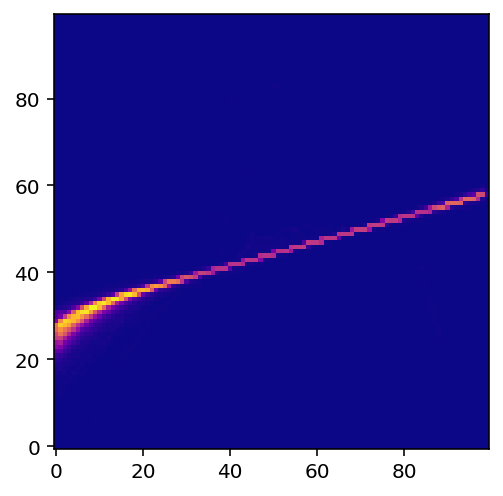

In [32]:
for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.sum(flights_average[:,:,i])}')

flatten_average = flatten_array(flights_average)
plt.imshow(flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))
plt.show()

In [40]:
import numpy as np
np.set_printoptions(precision=1)

def SARMSE(original, predicted):
  layer_rmse = np.sqrt(np.sum(np.square(original-predicted)/100**2, axis=(0,1)))
  return np.sum(layer_rmse)/original.shape[-1] # divided by channels

# Tests
a = np.expand_dims(np.zeros([100,100]), -1)
b = np.expand_dims(np.ones([100,100]), -1)
c = np.stack([np.zeros([100,100]), np.zeros([100,100])], -1)
d = np.stack([np.ones([100,100]), np.ones([100,100])], -1)

# print(RMSE(a,b,0,1))
# print(RMSE(a,a,0,1))
# print(RMSE(b,b,0,1))

# print(RMSE(c,d))
# print(RMSE(c,c,0,2))
# print(RMSE(d,d,0,2))

In [45]:
import random

sum = 0
random_days = random.sample(range(59), 10)
print(f'Random Days: {random_days}')
for i in random_days:
  random_hours = random.sample(range(24), 10)
  print(f'Random Hours: {random_hours}')
  for j in random_hours:
    sum += SARMSE(day_array[i, j, :, :, :], flights_average)

print(f'SARMSE: {sum/100}')

Random Days: [57, 11, 44, 49, 23, 42, 41, 37, 0, 9]
Random Hours: [17, 13, 4, 8, 0, 11, 6, 19, 3, 14]
Random Hours: [0, 9, 19, 3, 22, 18, 4, 15, 7, 12]
Random Hours: [3, 11, 4, 18, 20, 16, 19, 5, 7, 22]
Random Hours: [6, 1, 12, 9, 22, 23, 3, 14, 15, 8]
Random Hours: [5, 19, 16, 20, 9, 10, 1, 7, 21, 22]
Random Hours: [11, 9, 14, 16, 0, 22, 2, 13, 10, 23]
Random Hours: [14, 4, 21, 8, 6, 2, 19, 10, 18, 23]
Random Hours: [0, 20, 13, 7, 10, 16, 12, 5, 1, 2]
Random Hours: [4, 19, 1, 2, 12, 23, 8, 13, 14, 20]
Random Hours: [18, 10, 5, 23, 20, 13, 17, 2, 15, 6]
SARMSE: 0.02140320287323181


**Visualization**


In [46]:
# 2D Visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
%config InlineBackend.figure_format = 'retina'

def level_transform(input_array, hour):
  levels_array = []
  len_array = input_array[hour, ...].shape[-1]
  for i in range(0, len_array):
    level = input_array[hour, ..., i]*((i+2)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)


def browse_images(day_array):
    def view_hour(day, hour):
        plt.imshow(level_transform(day_array[day-1], hour), origin='lower', cmap = plt.get_cmap('plasma'))
        plt.show()
    interact(view_hour, day=widgets.IntSlider(min=1, max=day_array.shape[0], step=1, value=0), hour=widgets.IntSlider(min=0, max=23, step=1, value=0))

browse_images(day_array)

interactive(children=(IntSlider(value=1, description='day', max=59, min=1), IntSlider(value=0, description='ho…

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

def browse_images(day_array):
    def view_hour(day):
      fig, ax = plt.subplots(6, 4, figsize=(15, 15))
      for idx, ax in enumerate(ax.flat):
        ax.imshow(level_transform(day_array[day-1], idx), origin='lower', cmap = plt.get_cmap('plasma'))
        ax.set_title(f'Day {day} / Hour {idx}')
        ax.axis("off")
    
    interact(view_hour, day=widgets.IntSlider(min=1, max=day_array.shape[0], step=1, value=0))

browse_images(day_array)

interactive(children=(IntSlider(value=1, description='day', max=59, min=1), Output()), _dom_classes=('widget-i…

In [ ]:
# 3D Visualization
import plotly.graph_objects as go
import pandas as pd
import random

def ms(x, y, z, radius, resolution=5):
  u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
  X = radius * np.cos(u)*np.sin(v) + x
  Y = radius * np.sin(u)*np.sin(v) + y
  Z = radius * np.cos(v) + z
  return (X, Y, Z)

# Append spheres
day = 14
hour = 8

data = []
layers_df = pd.DataFrame(columns=['layer', 'x', 'y'])
cmap = plt.cm.get_cmap('plasma', 16)
for layer in range(0, day_array[day-1,...].shape[-1]): # looping layers
  layer_array = day_array[day-1, hour, ..., layer]
  
  for i in range(0, layer_array.shape[0]):
    for j in range(0, layer_array.shape[1]):
      if layer_array[i,j] == 1:
        layers_df.loc[len(layers_df)] = [layer, j, i]

data.append(go.Scatter3d(
          x= layers_df['x'],
          y= layers_df['y'],
          z= layers_df['layer'],
          name='layers',
          mode='markers',
          marker=dict(color=layers_df['layer'],colorscale='Plasma')))

layout = go.Layout(scene=dict(
  xaxis = dict(range=[0, 100]),
  yaxis = dict(range=[0, 100]),
  zaxis = dict(range=[-1, 20])))
        
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1, z=2)
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_camera=camera)
fig.show()

# ConvLSTM

In [35]:
x_train = day_array[0:40]
y_train = day_array[1:41]

x_val = day_array[41:51]
y_val = day_array[42:52]

x_test = day_array[52:58]
y_test = day_array[53:59]

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, MaxPooling3D

import io
import imageio

# Model 1

In [77]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

x = tf.keras.layers.Concatenate()([a, b, c])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)     (None, None, 100, 1  60032       ['input_3[0][0]']                
                                00, 32)                                                           
                                                                                                  
 conv_lstm2d_9 (ConvLSTM2D)     (None, None, 100, 1  57664       ['input_3[0][0]']                
                                00, 16)                                                     

# Model 2

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
layer1 = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

layer2 = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

layer3 = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = tf.keras.layers.Concatenate()([layer1, layer2, layer3])
# x = TimeDistributed(layers.BatchNormalization())(x)
# x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.Conv3D(
    filters=20, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 conv_lstm2d_6 (ConvLSTM2D)     (None, None, 100, 1  166528      ['input_3[0][0]']                
                                00, 32)                                                           
                                                                                                  
 conv_lstm2d_7 (ConvLSTM2D)     (None, None, 100, 1  20800       ['input_3[0][0]']                
                                00, 16)                                                     

# Model 3

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(
    filters=20, kernel_size=(10, 10, 10), activation="sigmoid", padding="same", data_format='channels_last'
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, 100, 100,   0         
                             20)]                                
                                                                 
 conv_lstm2d_40 (ConvLSTM2D)  (None, None, 100, 100, 3  326272   
                             2)                                  
                                                                 
 batch_normalization_34 (Bat  (None, None, 100, 100, 3  128      
 chNormalization)            2)                                  
                                                                 
 conv_lstm2d_41 (ConvLSTM2D)  (None, None, 100, 100, 1  76864    
                             6)                                  
                                                                 
 batch_normalization_35 (Bat  (None, None, 100, 100, 1  64

# Training

In [78]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
8/8 [==============================] - 13s 1s/step - loss: 0.3932 - val_loss: 0.3266 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 7s 865ms/step - loss: 0.2805 - val_loss: 0.2700 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 7s 863ms/step - loss: 0.2120 - val_loss: 0.2415 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - 7s 865ms/step - loss: 0.1533 - val_loss: 0.2142 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - 7s 858ms/step - loss: 0.1119 - val_loss: 0.1940 - lr: 0.0010
Epoch 6/30
8/8 [==============================] - 7s 866ms/step - loss: 0.0872 - val_loss: 0.1667 - lr: 0.0010
Epoch 7/30
8/8 [==============================] - 7s 863ms/step - loss: 0.0720 - val_loss: 0.1431 - lr: 0.0010
Epoch 8/30
8/8 [==============================] - 7s 875ms/step - loss: 0.0606 - val_loss: 0.1252 - lr: 0.0010
Epoch 9/30
8/8 [==============================] - 7s 863ms/step - loss: 0.0515 - val_loss: 0.1052 - lr: 0.0010
Epo

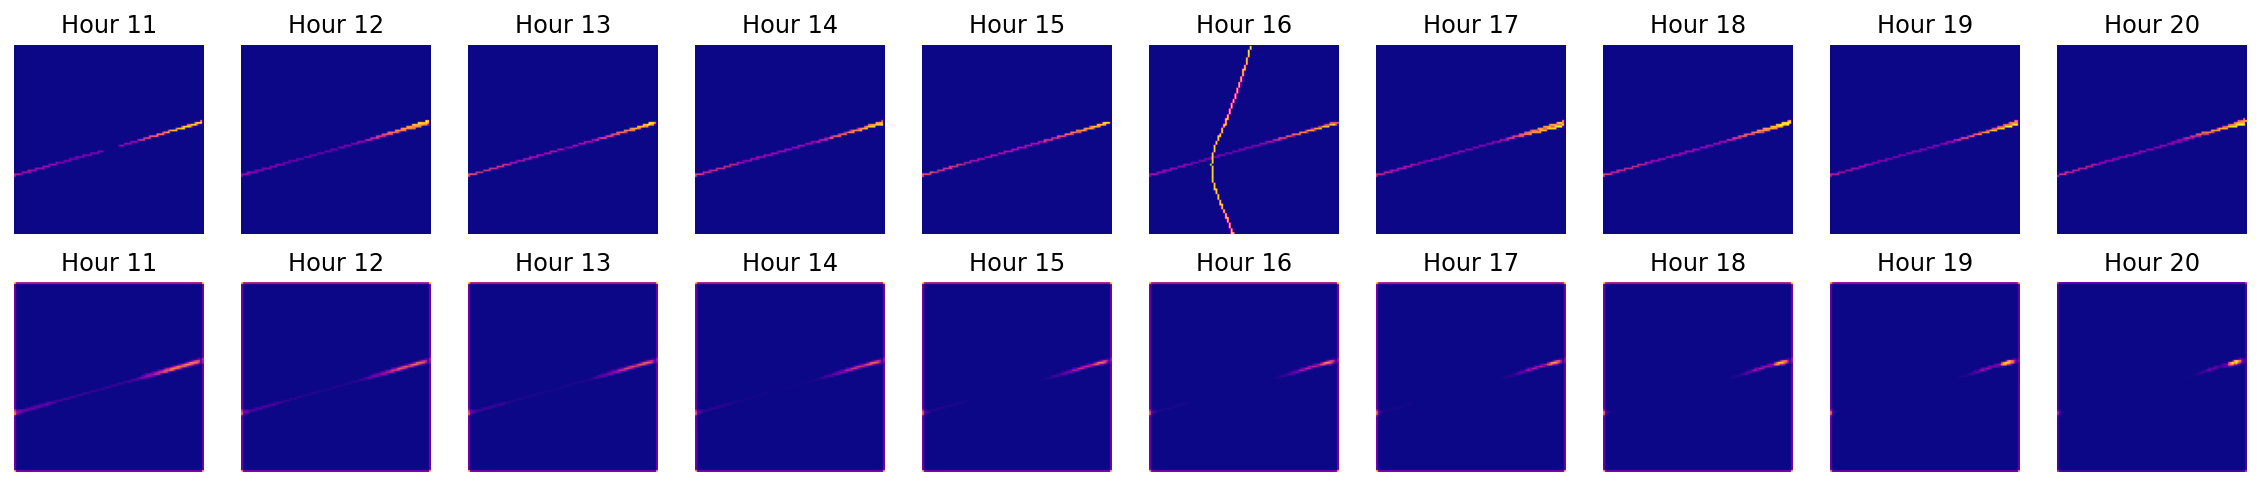

In [96]:
# Select a random example from the validation dataset.
example = x_test[3]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    # new_prediction[new_prediction > .5] = 1
    # new_prediction[new_prediction < .5] = 0

    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # predicted_frame = np.where(predicted_frame > 0.01, 1, 0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  
    ax.imshow(level_transform(original_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(original_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(level_transform(new_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(new_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

Text(0, 0.5, 'SARMSE (%)')

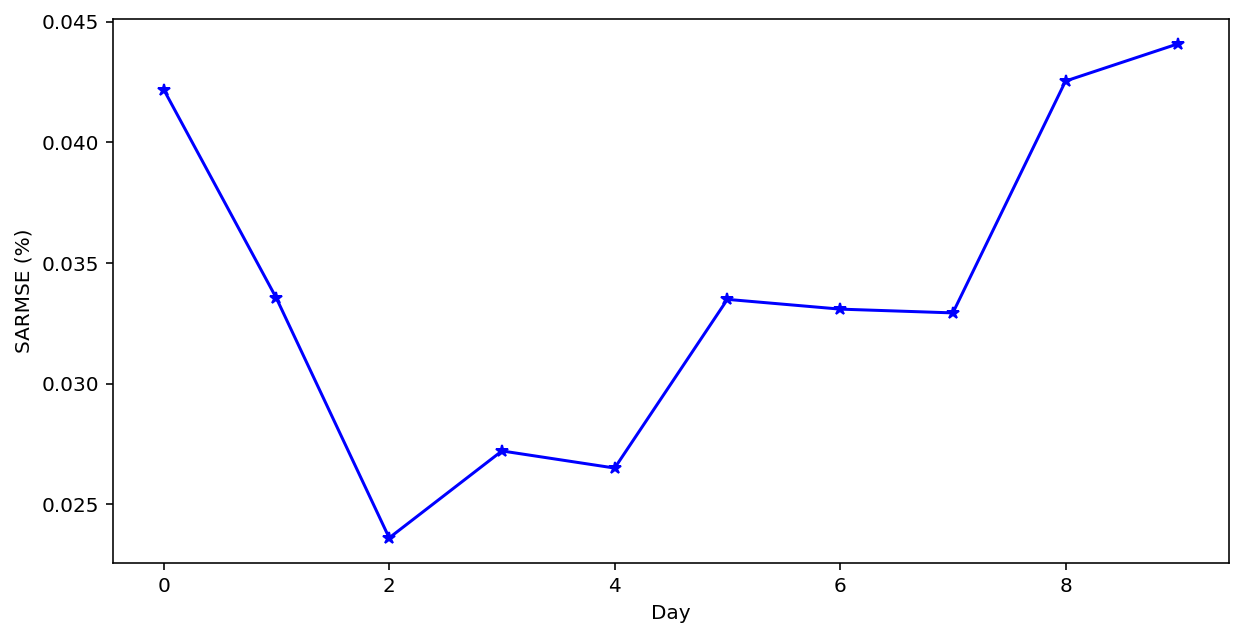

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))

SARMSE_list = []
for i in range(0, new_frames.shape[0]):
  SARMSE_list.append(SARMSE(original_frames[i], new_frames[i]))

ax.plot(SARMSE_list, 'b*-')
ax.set_xlabel('Day')
ax.set_ylabel('SARMSE (%)')